In [1]:
import numpy as np
import pandas as pd
import os
import datetime
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter("ignore")

In [4]:
import data_feeder

In [5]:
from sklearn.linear_model import LinearRegression

## Main Class

In [8]:
class PearsonBot:
    def __init__(self, timeframe: int = 30, min_linreg: int = 3) -> object:
        self.timeframe = timeframe
        self.min_linreg = min_linreg
        self.df_timeframe = pd.DataFrame()
        self.counter = 0
        self.m = np.nan
        self.c = np.nan
        self.process = True
        self.std = np.nan
        self.temp_flag = True
    
    def flush_counter(self):
        self.counter = 0
    
    def flush_df(self):
        self.df_timeframe = pd.DataFrame()
    
    def flush_coeffs(self):
        self.m = np.nan
        self.c = np.nan
    
    def flush_all(self):
        self.flush_df()
        self.flush_counter()
        self.flush_coeffs()
    
    def calc_hl2(self) -> None:
        self.df_timeframe['hl2'] = ((self.df_timeframe['High'] - self.df_timeframe['Low']) / 2) + self.df_timeframe['Low']
    
    def calc_coeffs(self, df):
        lr = LinearRegression()
        lr.fit(df[['index']], df['hl2'])
        self.m = lr.coef_
        self.c = lr.intercept_
    
    def lin_reg_fn(self, x):
        return (self.m * x) + self.c
    
    def calc_lr(self):
        self.calc_coeffs()
        self.df_timeframe['lin_reg'] = self.df_timeframe['index'].apply(self.lin_reg_fn)

    def on_tick(self, df: pd.DataFrame):
        if self.counter <= self.timeframe:
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            self.df_timeframe = pd.concat([self.df_timeframe, df])
        else:
            if self.process:
                self.calc_hl2()
                self.df_timeframe = self.df_timeframe.reset_index().drop(columns='index').reset_index()
                self.calc_lr()
                self.std = self.df_timeframe['hl2'].std()
                self.lin_reg_height = (self.df_timeframe['lin_reg'].max() - self.df_timeframe['lin_reg'].min())
                self.process = False
            else:
                print('monitoring...')
                self.flush_all()
                self.temp_flag = False      
    
    def display(self):
        self.df_timeframe[['hl2','lin_reg']].plot(figsize=(15,15))
    
    def main(self):
        for df in tqdm(data_feeder.get_ticks()):
            if self.temp_flag:
                self.on_tick()
            else:
                break
        
        self.display()

In [9]:
pb = PearsonBot()

In [10]:
pb.main()

TypeError: get_ticks() missing 1 required positional argument: 'df'

In [7]:
df = pd.read_csv("data/esapr.txt", sep=",")

In [9]:
df['Datetime'] = df['Date'] + " " + df['Time']
df

,Date,Time,Open,High,Low,Close,Up,Down,Datetime
0,04/01/2022,00:00:00,4547.75,4547.75,4547.25,4547.25,0,9,04/01/2022 00:00:00
1,04/01/2022,00:00:01,4547.25,4547.75,4547.25,4547.75,86,48,04/01/2022 00:00:01
2,04/01/2022,00:00:02,4547.50,4547.50,4546.50,4546.50,2,54,04/01/2022 00:00:02
3,04/01/2022,00:00:03,4546.25,4547.25,4546.25,4547.25,47,10,04/01/2022 00:00:03
4,04/01/2022,00:00:04,4547.00,4547.00,4546.50,4547.00,24,21,04/01/2022 00:00:04
...,...,...,...,...,...,...,...,...,...
943841,04/29/2022,13:59:56,4137.25,4138.00,4137.25,4138.00,47,1,04/29/2022 13:59:56
943842,04/29/2022,13:59:57,4137.50,4137.75,4137.50,4137.50,7,3,04/29/2022 13:59:57
943843,04/29/2022,13:59:58,4137.75,4137.75,4137.50,4137.50,4,2,04/29/2022 13:59:58
943844,04/29/2022,13:59:59,4137.00,4137.00,4137.00,4137.00,0,6,04/29/2022 13:59:59


In [10]:
df = df[['Datetime', 'Open', 'High', 'Low', 'Close']]

In [12]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [13]:
ohlc = {
    "Open":"first",
    "High":"max",
    "Low":"min",
    "Close":"last"
}

In [14]:
df_resampled = df.set_index('Datetime').resample("1T", closed="left", label="left").agg(ohlc)

In [17]:
df_resampled.dropna(subset=['Open'], inplace=True)

In [21]:
df_resampled.reset_index().to_csv("resampled.csv", index=False)

In [24]:
df = pd.read_csv("data/resampled.csv")
df

,Datetime,Open,High,Low,Close
0,2022-04-01 00:00:00,4547.75,4547.75,4546.00,4546.75
1,2022-04-01 00:01:00,4546.75,4547.25,4546.25,4546.75
2,2022-04-01 00:02:00,4546.50,4547.00,4544.50,4546.00
3,2022-04-01 00:03:00,4545.75,4546.50,4545.50,4546.25
4,2022-04-01 00:04:00,4546.25,4547.25,4545.25,4545.25
...,...,...,...,...,...
27069,2022-04-29 13:56:00,4137.50,4138.00,4137.00,4137.75
27070,2022-04-29 13:57:00,4137.50,4138.00,4137.50,4138.00
27071,2022-04-29 13:58:00,4138.00,4138.00,4136.25,4137.00
27072,2022-04-29 13:59:00,4136.75,4138.00,4135.25,4137.00


In [25]:
df['Datetime'].values[0]

'2022-04-01 00:00:00'

In [5]:
df = pd.read_excel("pnl.xlsx")

In [6]:
df.head()

,Datetime_entry,side,entry_price,DatetimeExit,exit_price,original_status
0,2022-05-02 07:03:00,short,4136.75,2022-05-02 07:04:00,4134.75,win
1,2022-05-02 07:05:00,long,4137.75,2022-05-02 07:06:00,4132.75,lose
2,2022-05-02 07:26:00,short,4147.75,2022-05-02 07:30:00,4152.75,lose
3,2022-05-02 07:44:00,long,4163.25,2022-05-02 07:45:00,4158.25,lose
4,2022-05-02 08:12:00,short,4124.50,2022-05-02 08:13:00,4122.50,win


In [8]:
df['Datetime_entry'] = pd.to_datetime(df['Datetime_entry'])
df['DatetimeExit'] = pd.to_datetime(df['DatetimeExit'])
df.head()

,Datetime_entry,side,entry_price,DatetimeExit,exit_price,original_status
0,2022-05-02 07:03:00,short,4136.75,2022-05-02 07:04:00,4134.75,win
1,2022-05-02 07:05:00,long,4137.75,2022-05-02 07:06:00,4132.75,lose
2,2022-05-02 07:26:00,short,4147.75,2022-05-02 07:30:00,4152.75,lose
3,2022-05-02 07:44:00,long,4163.25,2022-05-02 07:45:00,4158.25,lose
4,2022-05-02 08:12:00,short,4124.50,2022-05-02 08:13:00,4122.50,win


In [9]:
df['entry_date'] = df['Datetime_entry'].dt.date
df['entry_time'] = df['Datetime_entry'].dt.time

df['exit_date'] = df['DatetimeExit'].dt.date
df['exit_time'] = df['DatetimeExit'].dt.time

df.head()

,Datetime_entry,side,entry_price,DatetimeExit,exit_price,original_status,entry_date,entry_time,exit_date,exit_time
0,2022-05-02 07:03:00,short,4136.75,2022-05-02 07:04:00,4134.75,win,2022-05-02,07:03:00,2022-05-02,07:04:00
1,2022-05-02 07:05:00,long,4137.75,2022-05-02 07:06:00,4132.75,lose,2022-05-02,07:05:00,2022-05-02,07:06:00
2,2022-05-02 07:26:00,short,4147.75,2022-05-02 07:30:00,4152.75,lose,2022-05-02,07:26:00,2022-05-02,07:30:00
3,2022-05-02 07:44:00,long,4163.25,2022-05-02 07:45:00,4158.25,lose,2022-05-02,07:44:00,2022-05-02,07:45:00
4,2022-05-02 08:12:00,short,4124.50,2022-05-02 08:13:00,4122.50,win,2022-05-02,08:12:00,2022-05-02,08:13:00


In [10]:
df = df[['entry_date', 'entry_time', 'exit_date', 'exit_time', 'original_status', 'side', 'entry_price', 'exit_price']]
df.head()

,entry_date,entry_time,exit_date,exit_time,original_status,side,entry_price,exit_price
0,2022-05-02,07:03:00,2022-05-02,07:04:00,win,short,4136.75,4134.75
1,2022-05-02,07:05:00,2022-05-02,07:06:00,lose,long,4137.75,4132.75
2,2022-05-02,07:26:00,2022-05-02,07:30:00,lose,short,4147.75,4152.75
3,2022-05-02,07:44:00,2022-05-02,07:45:00,lose,long,4163.25,4158.25
4,2022-05-02,08:12:00,2022-05-02,08:13:00,win,short,4124.50,4122.50


In [13]:
df['pnl'] = df['exit_price'] - df['entry_price']
df['pnl%'] = (df['exit_price'] / df['entry_price']) - 1
df.head()

,entry_date,entry_time,exit_date,exit_time,original_status,side,entry_price,exit_price,pnl,pnl%,pnl%_adj
0,2022-05-02,07:03:00,2022-05-02,07:04:00,win,short,4136.75,4134.75,-2.0,-0.000483,-0.000484
1,2022-05-02,07:05:00,2022-05-02,07:06:00,lose,long,4137.75,4132.75,-5.0,-0.001208,0.001210
2,2022-05-02,07:26:00,2022-05-02,07:30:00,lose,short,4147.75,4152.75,5.0,0.001205,0.001204
3,2022-05-02,07:44:00,2022-05-02,07:45:00,lose,long,4163.25,4158.25,-5.0,-0.001201,0.001202
4,2022-05-02,08:12:00,2022-05-02,08:13:00,win,short,4124.50,4122.50,-2.0,-0.000485,-0.000485


In [14]:
df['pnl%_adj'] = np.where(df['side'] == "short", -1, 1) * df['pnl%']
df.head()

,entry_date,entry_time,exit_date,exit_time,original_status,side,entry_price,exit_price,pnl,pnl%,pnl%_adj
0,2022-05-02,07:03:00,2022-05-02,07:04:00,win,short,4136.75,4134.75,-2.0,-0.000483,0.000483
1,2022-05-02,07:05:00,2022-05-02,07:06:00,lose,long,4137.75,4132.75,-5.0,-0.001208,-0.001208
2,2022-05-02,07:26:00,2022-05-02,07:30:00,lose,short,4147.75,4152.75,5.0,0.001205,-0.001205
3,2022-05-02,07:44:00,2022-05-02,07:45:00,lose,long,4163.25,4158.25,-5.0,-0.001201,-0.001201
4,2022-05-02,08:12:00,2022-05-02,08:13:00,win,short,4124.50,4122.50,-2.0,-0.000485,0.000485


In [15]:
df['status'] = np.where(df['pnl%_adj'] > 0, "win", "lose")
df

,entry_date,entry_time,exit_date,exit_time,original_status,side,entry_price,exit_price,pnl,pnl%,pnl%_adj,status
0,2022-05-02,07:03:00,2022-05-02,07:04:00,win,short,4136.75,4134.75,-2.0,-0.000483,0.000483,win
1,2022-05-02,07:05:00,2022-05-02,07:06:00,lose,long,4137.75,4132.75,-5.0,-0.001208,-0.001208,lose
2,2022-05-02,07:26:00,2022-05-02,07:30:00,lose,short,4147.75,4152.75,5.0,0.001205,-0.001205,lose
3,2022-05-02,07:44:00,2022-05-02,07:45:00,lose,long,4163.25,4158.25,-5.0,-0.001201,-0.001201,lose
4,2022-05-02,08:12:00,2022-05-02,08:13:00,win,short,4124.50,4122.50,-2.0,-0.000485,0.000485,win
...,...,...,...,...,...,...,...,...,...,...,...,...
311,2022-05-23,12:26:00,2022-05-23,12:28:00,win,long,3964.00,3966.00,2.0,0.000505,0.000505,win
312,2022-05-23,12:39:00,2022-05-23,12:40:00,lose,long,3965.00,3960.00,-5.0,-0.001261,-0.001261,lose
313,2022-05-23,12:43:00,2022-05-23,12:44:00,lose,long,3964.25,3959.25,-5.0,-0.001261,-0.001261,lose
314,2022-05-23,12:51:00,2022-05-23,12:54:00,win,short,3963.00,3961.00,-2.0,-0.000505,0.000505,win


In [16]:
df = df[['entry_date','entry_time','exit_date','exit_time','entry_price','exit_price','pnl','pnl%','pnl%_adj','side','status','original_status']]
df.head()

,entry_date,entry_time,exit_date,exit_time,entry_price,exit_price,pnl,pnl%,pnl%_adj,side,status,original_status
0,2022-05-02,07:03:00,2022-05-02,07:04:00,4136.75,4134.75,-2.0,-0.000483,0.000483,short,win,win
1,2022-05-02,07:05:00,2022-05-02,07:06:00,4137.75,4132.75,-5.0,-0.001208,-0.001208,long,lose,lose
2,2022-05-02,07:26:00,2022-05-02,07:30:00,4147.75,4152.75,5.0,0.001205,-0.001205,short,lose,lose
3,2022-05-02,07:44:00,2022-05-02,07:45:00,4163.25,4158.25,-5.0,-0.001201,-0.001201,long,lose,lose
4,2022-05-02,08:12:00,2022-05-02,08:13:00,4124.50,4122.50,-2.0,-0.000485,0.000485,short,win,win


In [17]:
df[df['status'] != df['original_status']]

,entry_date,entry_time,exit_date,exit_time,entry_price,exit_price,pnl,pnl%,pnl%_adj,side,status,original_status
221,2022-05-16,13:30:00,2022-05-16,14:00:00,4001.00,3997.75,-3.25,-0.000812,0.000812,short,win,END local
277,2022-05-19,13:44:00,2022-05-19,14:00:00,3897.75,3898.25,0.50,0.000128,-0.000128,short,lose,END local


In [18]:
df.to_csv("final_pnl_rounded.csv", index=False)

In [20]:
df['cuml_rtns'] = np.cumsum(df['pnl%_adj'])
df.head()

,entry_date,entry_time,exit_date,exit_time,entry_price,exit_price,pnl,pnl%,pnl%_adj,side,status,original_status,cuml_rtns
0,2022-05-02,07:03:00,2022-05-02,07:04:00,4136.75,4134.75,-2.0,-0.000483,0.000483,short,win,win,0.000483
1,2022-05-02,07:05:00,2022-05-02,07:06:00,4137.75,4132.75,-5.0,-0.001208,-0.001208,long,lose,lose,-0.000725
2,2022-05-02,07:26:00,2022-05-02,07:30:00,4147.75,4152.75,5.0,0.001205,-0.001205,short,lose,lose,-0.001930
3,2022-05-02,07:44:00,2022-05-02,07:45:00,4163.25,4158.25,-5.0,-0.001201,-0.001201,long,lose,lose,-0.003131
4,2022-05-02,08:12:00,2022-05-02,08:13:00,4124.50,4122.50,-2.0,-0.000485,0.000485,short,win,win,-0.002646


In [24]:
df.reset_index(inplace=True)

<AxesSubplot:>

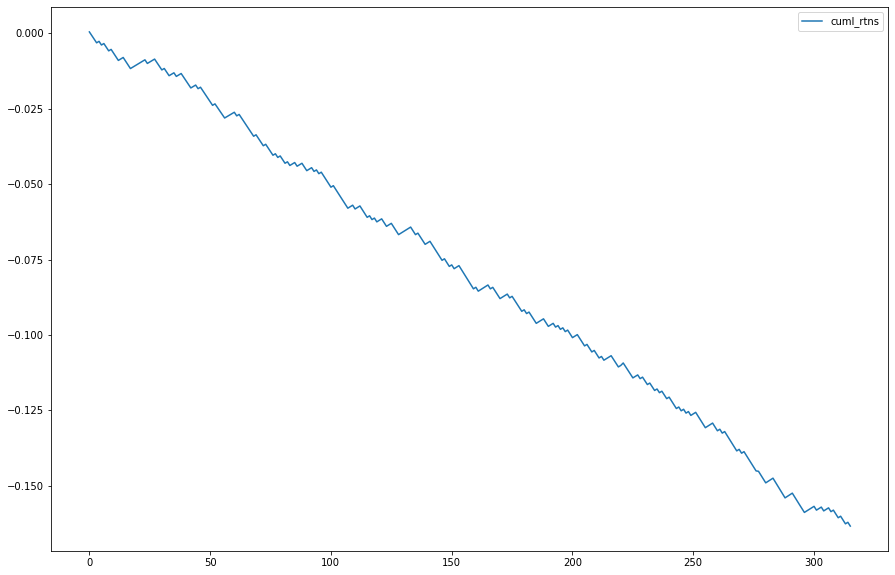

In [30]:
df[['cuml_rtns']].plot(figsize=(15, 10))

In [26]:
df['Datetime_entry'] = pd.to_datetime(df['Datetime_entry'])
df['Datetime_exit'] = pd.to_datetime(df['Datetime_exit'])
df

,Datetime_entry,side,entry_price,Datetime_exit,exit_price,pnl,pnl%,pnl%_adj,status
0,2022-04-01 08:10:00,long,4535.070898,2022-04-01 08:15:00,4536.536875,-1.465978,-0.000323,-0.000323,lose
1,2022-04-01 09:11:00,long,4511.348326,2022-04-01 09:14:00,4510.522872,0.825454,0.000183,0.000183,win
2,2022-04-01 09:44:00,short,4512.684963,2022-04-01 10:00:00,4513.377705,-0.692742,-0.000153,0.000153,win
3,2022-04-01 11:12:00,short,4523.711343,2022-04-01 11:15:00,4524.492492,-0.781149,-0.000173,0.000173,win
4,2022-04-01 11:26:00,short,4527.356706,2022-04-01 11:29:00,4528.137855,-0.781149,-0.000173,0.000173,win
...,...,...,...,...,...,...,...,...,...
264,2022-04-29 12:11:00,short,4153.690702,2022-04-29 12:13:00,4152.571448,1.119254,0.000270,-0.000270,lose
265,2022-04-29 12:14:00,long,4152.011821,2022-04-29 12:15:00,4151.452194,0.559627,0.000135,0.000135,win
266,2022-04-29 12:32:00,short,4150.973658,2022-04-29 12:33:00,4150.678446,0.295212,0.000071,-0.000071,lose
267,2022-04-29 12:46:00,long,4146.840694,2022-04-29 12:47:00,4146.545483,0.295212,0.000071,0.000071,win


In [27]:
df['entry_date'] = df['Datetime_entry'].dt.date
df['entry_time'] = df['Datetime_entry'].dt.time

df['exit_date'] = df['Datetime_exit'].dt.date
df['exit_time'] = df['Datetime_exit'].dt.time

df

,Datetime_entry,side,entry_price,Datetime_exit,exit_price,pnl,pnl%,pnl%_adj,status,entry_date,entry_time,exit_date,exit_time
0,2022-04-01 08:10:00,long,4535.070898,2022-04-01 08:15:00,4536.536875,-1.465978,-0.000323,-0.000323,lose,2022-04-01,08:10:00,2022-04-01,08:15:00
1,2022-04-01 09:11:00,long,4511.348326,2022-04-01 09:14:00,4510.522872,0.825454,0.000183,0.000183,win,2022-04-01,09:11:00,2022-04-01,09:14:00
2,2022-04-01 09:44:00,short,4512.684963,2022-04-01 10:00:00,4513.377705,-0.692742,-0.000153,0.000153,win,2022-04-01,09:44:00,2022-04-01,10:00:00
3,2022-04-01 11:12:00,short,4523.711343,2022-04-01 11:15:00,4524.492492,-0.781149,-0.000173,0.000173,win,2022-04-01,11:12:00,2022-04-01,11:15:00
4,2022-04-01 11:26:00,short,4527.356706,2022-04-01 11:29:00,4528.137855,-0.781149,-0.000173,0.000173,win,2022-04-01,11:26:00,2022-04-01,11:29:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2022-04-29 12:11:00,short,4153.690702,2022-04-29 12:13:00,4152.571448,1.119254,0.000270,-0.000270,lose,2022-04-29,12:11:00,2022-04-29,12:13:00
265,2022-04-29 12:14:00,long,4152.011821,2022-04-29 12:15:00,4151.452194,0.559627,0.000135,0.000135,win,2022-04-29,12:14:00,2022-04-29,12:15:00
266,2022-04-29 12:32:00,short,4150.973658,2022-04-29 12:33:00,4150.678446,0.295212,0.000071,-0.000071,lose,2022-04-29,12:32:00,2022-04-29,12:33:00
267,2022-04-29 12:46:00,long,4146.840694,2022-04-29 12:47:00,4146.545483,0.295212,0.000071,0.000071,win,2022-04-29,12:46:00,2022-04-29,12:47:00


In [28]:
df = df[['entry_date','entry_time','entry_price','exit_date','exit_time','exit_price','side','pnl','pnl%','pnl%_adj']]
df

,entry_date,entry_time,entry_price,exit_date,exit_time,exit_price,side,pnl,pnl%,pnl%_adj
0,2022-04-01,08:10:00,4535.070898,2022-04-01,08:15:00,4536.536875,long,-1.465978,-0.000323,-0.000323
1,2022-04-01,09:11:00,4511.348326,2022-04-01,09:14:00,4510.522872,long,0.825454,0.000183,0.000183
2,2022-04-01,09:44:00,4512.684963,2022-04-01,10:00:00,4513.377705,short,-0.692742,-0.000153,0.000153
3,2022-04-01,11:12:00,4523.711343,2022-04-01,11:15:00,4524.492492,short,-0.781149,-0.000173,0.000173
4,2022-04-01,11:26:00,4527.356706,2022-04-01,11:29:00,4528.137855,short,-0.781149,-0.000173,0.000173
...,...,...,...,...,...,...,...,...,...,...
264,2022-04-29,12:11:00,4153.690702,2022-04-29,12:13:00,4152.571448,short,1.119254,0.000270,-0.000270
265,2022-04-29,12:14:00,4152.011821,2022-04-29,12:15:00,4151.452194,long,0.559627,0.000135,0.000135
266,2022-04-29,12:32:00,4150.973658,2022-04-29,12:33:00,4150.678446,short,0.295212,0.000071,-0.000071
267,2022-04-29,12:46:00,4146.840694,2022-04-29,12:47:00,4146.545483,long,0.295212,0.000071,0.000071


In [20]:
df[df['exit_time'] >= datetime.time(14, 1, 0)]

,entry_date,entry_time,entry_price,exit_date,exit_time,exit_price,side,pnl,pnl%,pnl%_adj
